# Лабораторная работа 4

## Случайный лес

В начале всё схоже с прошлыми лабораторными

В этом блоке я подключаю все нужные библиотеки которые использую в лабораторной работе

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

sns.set(style="whitegrid")

## SPAM SMS

Загружаю датасет со спам сообщениями и разделяю сообщения на признаки и метки, а затем делю данные на обучающую и тестовую выборки

In [ ]:
spam_path = "/content/spam.csv"

spam_df = pd.read_csv(spam_path, encoding="latin1")[["v1", "v2"]]
spam_df.columns = ["label", "message"]

print("Размер датасета:", spam_df.shape)
display(spam_df.head())
print("\nРаспределение классов:")
print(spam_df["label"].value_counts())

X = spam_df["message"]
y = spam_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nОбучающая выборка:", len(X_train))
print("Тестовая выборка :", len(X_test))

Размер датасета: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Распределение классов:
label
ham     4825
spam     747
Name: count, dtype: int64

Обучающая выборка: 4457
Тестовая выборка : 1115


базовая модель случайный лес

Строю базовую модель случайного леса для классификации спам-сообщений

Сначала TF-IDF превращает текст в числовые признаки, а затем RandomForestClassifier обучается на этих векторах

Я беру лес из 100 деревьев и после обучения и теста на тестовых данных считаю метрики. И строю матрицу ошибок


=== Базовый случайный лес (спам) ===
Accuracy : 0.9749
Precision: 1.0000
Recall   : 0.8121
F1 (spam): 0.8963

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



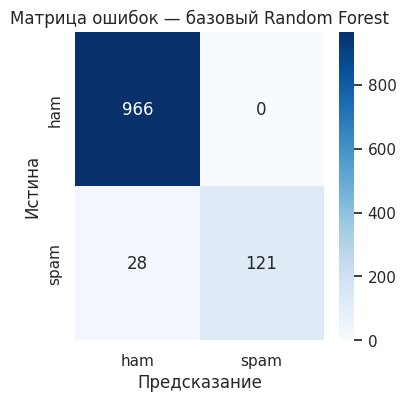

In [ ]:
rf_clf_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf_base.fit(X_train, y_train)
y_pred_base = rf_clf_base.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, pos_label="spam")
rec_base = recall_score(y_test, y_pred_base, pos_label="spam")
f1_base = f1_score(y_test, y_pred_base, pos_label="spam")

print("\n=== Базовый случайный лес (спам) ===")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1 (spam): {f1_base:.4f}\n")
print(classification_report(y_test, y_pred_base))

cm_base = confusion_matrix(y_test, y_pred_base, labels=["ham", "spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок — базовый Random Forest")
plt.show()

### Гипотезы как можно улучшить модели:

- увеличить количество деревьев n_estimators для более стабильных предсказаний

- ограничить глубину отдельных деревьев max_depth

- использовать подвыборку признаков max_features для уменьшения корреляции между деревьями

- подобрать параметры модели с помощью GridSearch

Улучшенная модель

В этом блоке я улучшаю модель случайного леса с помощью GridSearchCV.
Сначала снова создаю пайплайн, где TF-IDF преобразует текст а RandomForestClassifier выполняет классификацию.
Затем я задаю сетку параметров, которые хочу перебрать.

GridSearchCV перебирает все комбинации параметров и выбирает ту, которая даёт лучший F1 на кросс валидации
После этого я обучаю модель с лучшими найденными параметрами и считаю метрики

Строю новую матрицу ошибок и таблицу сравнения

Fitting 3 folds for each of 96 candidates, totalling 288 fits

Лучшие параметры (классификация):
{'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_split': 5, 'rf__n_estimators': 200, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Лучший F1 (cv): 0.9535063670205921

=== Улучшенный случайный лес (спам) ===
Accuracy : 0.9794
Precision: 1.0000
Recall   : 0.8456
F1 (spam): 0.9164

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



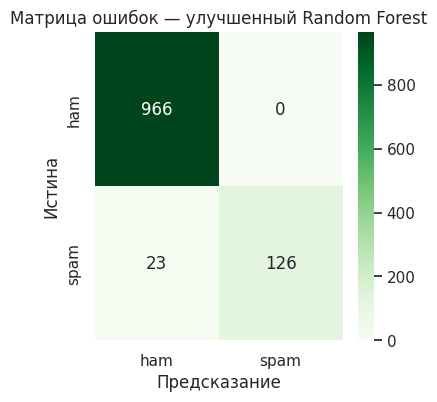


Сравнение моделей (классификация):


,model,accuracy,precision_spam,recall_spam,f1_spam
0,baseline,0.974888,1.0,0.812081,0.896296
1,improved,0.979372,1.0,0.845638,0.916364


In [ ]:
pipe_clf = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_clf = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 3],
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5],
    "rf__max_features": ["sqrt", "log2"]
}

grid_clf = GridSearchCV(
    pipe_clf,
    param_grid_clf,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train, y_train)

print("\nЛучшие параметры (классификация):")
print(grid_clf.best_params_)
print("Лучший F1 (cv):", grid_clf.best_score_)

best_rf_clf = grid_clf.best_estimator_
y_pred_best = best_rf_clf.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, pos_label="spam")
rec_best = recall_score(y_test, y_pred_best, pos_label="spam")
f1_best = f1_score(y_test, y_pred_best, pos_label="spam")

print("\n=== Улучшенный случайный лес (спам) ===")
print(f"Accuracy : {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1 (spam): {f1_best:.4f}\n")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=["ham", "spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок — улучшенный Random Forest")
plt.show()

comp_clf = pd.DataFrame({
    "model": ["baseline", "improved"],
    "accuracy": [acc_base, acc_best],
    "precision_spam": [prec_base, prec_best],
    "recall_spam": [rec_base, rec_best],
    "f1_spam": [f1_base, f1_best]
})
print("\nСравнение моделей (классификация):")
display(comp_clf)

## Рейтинг фильмов

регрессия

Читаю только 50 тысяч строк, чтобы работа была быстрее и не перегружала память.

Сначала с помощью регулярного выражения я вытаскиваю год из названия фильма. Если года нет то строка удаляется. Затем я превращаю строку с жанрами в список жанров и кодирую их в набор бинарных признаков через multilabelbinizer

Потом формирую итоговую таблицу признаков куда входят рейтинги, год выхода фильма и закодированные жанры.
Получив датасет делю его на обучающую и тестовую части.


In [ ]:
ratings_path = "/content/rating.csv"
movies_path = "/content/movie.csv"

ratings_df = pd.read_csv(ratings_path, nrows=50000)
movies_df = pd.read_csv(movies_path)

print("\nРазмер ratings:", ratings_df.shape)
print("Размер movies :", movies_df.shape)

data_ml = ratings_df.merge(movies_df, on="movieId", how="left")
print("Размер объединённой таблицы:", data_ml.shape)
display(data_ml.head())

# извлекаем год и жанры
import re

def extract_year(title):
    m = re.search(r"(19\d{2}|20\d{2})", str(title))
    return int(m.group(0)) if m else np.nan

data_ml["year"] = data_ml["title"].apply(extract_year)
data_ml = data_ml.dropna(subset=["year"])

data_ml["genres_list"] = data_ml["genres"].fillna("(no genres listed)").apply(
    lambda s: s.split("|")
)

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(data_ml["genres_list"])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_])

features_ml = pd.concat(
    [data_ml[["rating", "year"]].reset_index(drop=True),
     genres_df.reset_index(drop=True)],
    axis=1
)

print("\nРазмер таблицы признаков:", features_ml.shape)
display(features_ml.head())

X_reg = features_ml.drop(columns=["rating"])
y_reg = features_ml["rating"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("\nРегрессия train:", X_reg_train.shape)
print("Регрессия test :", X_reg_test.shape)



Размер ratings: (50000, 4)
Размер movies : (27278, 3)
Размер объединённой таблицы: (50000, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller



Размер таблицы признаков: (50000, 21)


,rating,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,3.5,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.5,1995,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,3.5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0



Регрессия train: (40000, 20)
Регрессия test : (10000, 20)


строю базовую модель случайного леса для задачи регрессии

Я использую RandomForestRegressor без подбора параметров: просто 100 деревьев и фиксированный random_state. Потом считаю метрики и строю график истина vs предсказание.


=== Базовый случайный лес (регрессия) ===
MAE : 0.7879
RMSE: 1.0076
R^2 : 0.0945


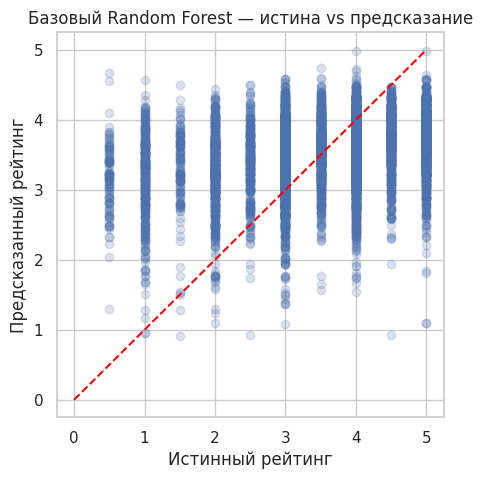

In [ ]:
rf_reg_base = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_reg_base.fit(X_reg_train, y_reg_train)
y_reg_pred_base = rf_reg_base.predict(X_reg_test)

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base = mean_squared_error(y_reg_test, y_reg_pred_base)**0.5
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print("\n=== Базовый случайный лес (регрессия) ===")
print(f"MAE : {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R^2 : {r2_base:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_reg_pred_base, alpha=0.2)
plt.xlabel("Истинный рейтинг")
plt.ylabel("Предсказанный рейтинг")
plt.title("Базовый Random Forest — истина vs предсказание")
plt.plot([0,5],[0,5],"--",color="red")
plt.show()


улучшенный рандом форест для регрессии

В этом блоке я улучшаю модель случайного леса для регрессии с помощью GridSearchCV.
Сначала данные проходят через StandardScaler чтобы признаки были на одном масштабе и после этого подаются в RandomForestRegressor.
Далее меняю количество деревьев, глубину, минимальное число объектов для разбиения и стратегию выбора признаков.

GridSearchCV перебирает все комбинации с кросс валидацией и выбирает те, которые дают минимальную MAE.
После настройки я обучаю модель с лучшими найденными параметрами и предсказываю рейтинги на тестовой выборке.

Потом считаю метрики, строю график и таблицу сравнения

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Лучшие параметры (регрессия):
{'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Лучший MAE (cv): 0.7959010005185583

=== Улучшенный случайный лес (регрессия) ===
MAE : 0.7830
RMSE: 1.0008
R^2 : 0.1066


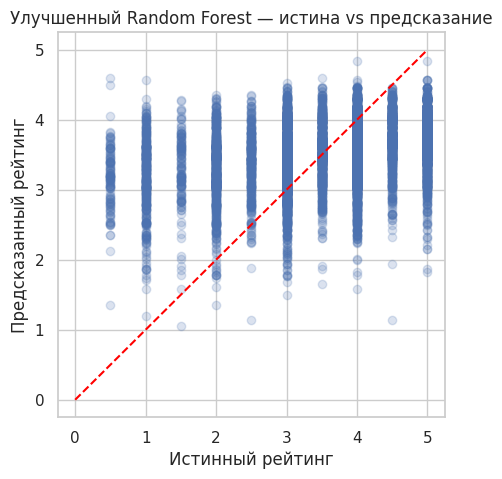


Сравнение моделей (регрессия):


,model,MAE,RMSE,R2
0,baseline,0.78788,1.007586,0.094519
1,improved,0.78299,1.000816,0.106646


In [ ]:
pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid_reg = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5],
    "rf__max_features": ["sqrt", "log2"]
}

grid_reg = GridSearchCV(
    pipe_reg,
    param_grid_reg,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_reg_train, y_reg_train)

print("\nЛучшие параметры (регрессия):")
print(grid_reg.best_params_)
print("Лучший MAE (cv):", -grid_reg.best_score_)

best_rf_reg = grid_reg.best_estimator_
y_reg_pred_best = best_rf_reg.predict(X_reg_test)

mae_best = mean_absolute_error(y_reg_test, y_reg_pred_best)
rmse_best = mean_squared_error(y_reg_test, y_reg_pred_best)**0.5
r2_best = r2_score(y_reg_test, y_reg_pred_best)

print("\n=== Улучшенный случайный лес (регрессия) ===")
print(f"MAE : {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"R^2 : {r2_best:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_reg_pred_best, alpha=0.2)
plt.xlabel("Истинный рейтинг")
plt.ylabel("Предсказанный рейтинг")
plt.title("Улучшенный Random Forest — истина vs предсказание")
plt.plot([0,5],[0,5],"--",color="red")
plt.show()

comp_reg = pd.DataFrame({
    "model": ["baseline", "improved"],
    "MAE": [mae_base, mae_best],
    "RMSE": [rmse_base, rmse_best],
    "R2": [r2_base, r2_best]
})
print("\nСравнение моделей (регрессия):")
display(comp_reg)

реализация дерева решений из лр3

best_split перебирает все признаки и возможные пороги и ищет такой разрез, который лучше всего делит выборку.

build_tree рекурсивно строит дерево: если глубина стала слишком большой или данных мало, то создаётся лист. Лист хранит либо среднее значение (для регрессии), либо наиболее частый класс (для классификации).

predict_one проходит по дереву от корня до листа и выбирает нужную ветку в зависимости от порога.

In [ ]:
import numpy as np
from collections import Counter

class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, task="classification"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.tree = None

    def best_split(self, X, y):
        n, d = X.shape
        best_feat, best_thr = None, None
        best_impurity = 1e18

        for feat in range(d):
            values = np.unique(X[:, feat])
            for thr in values:
                left = y[X[:, feat] <= thr]
                right = y[X[:, feat] > thr]

                if len(left) == 0 or len(right) == 0:
                    continue

                if self.task == "classification":
                    def gini(x):
                        c = Counter(x)
                        return 1 - sum((v/len(x))**2 for v in c.values())
                    impurity = (len(left)*gini(left) + len(right)*gini(right)) / len(y)
                else:
                    impurity = ((left - left.mean())**2).mean() + ((right - right.mean())**2).mean()

                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feat = feat
                    best_thr = thr

        return best_feat, best_thr

    def build_tree(self, X, y, depth=0):
        if len(y) < self.min_samples_split:
            return y.mean() if self.task == "regression" else Counter(y).most_common(1)[0][0]

        if self.max_depth is not None and depth >= self.max_depth:
            return y.mean() if self.task == "regression" else Counter(y).most_common(1)[0][0]

        feat, thr = self.best_split(X, y)
        if feat is None:
            return y.mean() if self.task == "regression" else Counter(y).most_common(1)[0][0]

        left_idx = X[:, feat] <= thr
        right_idx = ~left_idx

        return {
            "feat": feat,
            "thr": thr,
            "left": self.build_tree(X[left_idx], y[left_idx], depth+1),
            "right": self.build_tree(X[right_idx], y[right_idx], depth+1)
        }

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.tree = self.build_tree(X, y)
        return self

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feat"]] <= node["thr"]:
            return self.predict_one(x, node["left"])
        return self.predict_one(x, node["right"])

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self.predict_one(x, self.tree) for x in X])


имплементация random forest

Тут я реализую свой вариант рандом фореста. Идея такая же, как в sklearn, но сильно упрощённая. Лес состоит из нескольких деревьев, и каждое дерево учится на своей версии данных.

Сначала в конструкторе я задаю основные параметры: количество деревьев, максимальную глубину, минимальный размер разбиения, число случайных признаков и тип. Массив self.trees будет хранить пары: само дерево и набор признаков, который оно использует. Метод bootstrap делает бутстрап то бишь случайно выбирает обучающие примеры с возвратом.
Метод select_features случайно выбирает подмножество признаков. Это тоже важная часть случайного леса — каждое дерево видит только часть входных фич.

В методе predict я получаю предсказания всех деревьев и объединяю их.

In [ ]:
class MyRandomForest:
    def __init__(self, n_estimators=10, max_depth=None,
                 min_samples_split=2, max_features=None, task="classification"):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.task = task
        self.trees = []

    def bootstrap(self, X, y):
        n = len(y)
        idx = np.random.choice(n, n, replace=True)
        return X[idx], y[idx]

    def select_features(self, X):
        d = X.shape[1]
        if self.max_features is None:
            return np.arange(d)
        k = self.max_features
        feats = np.random.choice(d, k, replace=False)
        return feats

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.trees = []

        for _ in range(self.n_estimators):
            X_bs, y_bs = self.bootstrap(X, y)
            feats = self.select_features(X_bs)

            tree = MyDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                task=self.task
            )

            tree.fit(X_bs[:, feats], y_bs)
            self.trees.append((tree, feats))

        return self

    def predict(self, X):
        X = np.asarray(X)

        preds = []
        for tree, feats in self.trees:
            preds.append(tree.predict(X[:, feats]))

        preds = np.array(preds)

        if self.task == "classification":
            final = []
            for col in preds.T:
                final.append(Counter(col).most_common(1)[0][0])
            return np.array(final)

        return preds.mean(axis=0)


классификация

Здесь я подготавливаю текстовые данные и обучаю свой самодельный случайный лес для задачи классификации спама.
Сначала я создаю компактный TF-IDF векторизатор: ограничиваю количество признаков, убираю редкие слова и добавляю биграммы. Затем преобразую обучающие и тестовые сообщения в числовые векторы, а метки перевожу в 0 и 1.

Далее создаю свой randomforest с небольшим количеством деревьев и ограниченной глубиной, чтобы он работал быстрее и после этого обучаю модель на обучающей выборке и получаю предсказания на тестовой.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_small = TfidfVectorizer(
    stop_words="english",
    max_features=3000,
    min_df=3,
    ngram_range=(1,2)
)

X_train_vec = tfidf_small.fit_transform(X_train).toarray()
X_test_vec = tfidf_small.transform(X_test).toarray()

y_train_cls = (y_train == "spam").astype(int).values
y_test_cls  = (y_test == "spam").astype(int).values

my_forest = MyRandomForest(
    n_estimators=8,
    max_depth=10,
    min_samples_split=5,
    max_features=300,     # случайная подвыборка фич
    task="classification"
)

my_forest.fit(X_train_vec, y_train_cls)
y_pred_my = my_forest.predict(X_test_vec)


метрики

В этом блоке я считаю метрики для классификации и потом вывожу сравнительную таблицу

In [ ]:
acc_my = accuracy_score(y_test_cls, y_pred_my)
prec_my = precision_score(y_test_cls, y_pred_my)
rec_my = recall_score(y_test_cls, y_pred_my)
f1_my = f1_score(y_test_cls, y_pred_my)

print("=== Мой Random Forest (классификация) ===")
print("Accuracy:", acc_my)
print("Precision:", prec_my)
print("Recall:", rec_my)
print("F1:", f1_my)

pd.DataFrame({
    "model": ["sklearn_best", "my_forest"],
    "accuracy": [acc_best, acc_my],
    "precision": [prec_best, prec_my],
    "recall": [rec_best, rec_my],
    "f1": [f1_best, f1_my]
})


=== Мой Random Forest (классификация) ===
Accuracy: 0.8986547085201794
Precision: 1.0
Recall: 0.24161073825503357
F1: 0.3891891891891892


,model,accuracy,precision,recall,f1
0,sklearn_best,0.979372,1.0,0.845638,0.916364
1,my_forest,0.898655,1.0,0.241611,0.389189


улучшенный

В этом блоке я создаю улучшенную версию моего случайного леса, где вручную подставляю лучшие гиперпараметры которые были найдены через GridSearch у модели sklearn.
Я задаю глубину дерева и минимальное число объектов для разбиения такими же, как в лучшей модели, но по прежнему оставляю лес маленьким, чтобы он быстрее работал, потому что по другому он не считается

In [ ]:
best_params = {
    "tree__max_depth": 10,
    "tree__min_samples_split": 5
}

my_forest_imp = MyRandomForest(
    n_estimators=5,                           # маленький лес
    max_depth=best_params["tree__max_depth"],
    min_samples_split=best_params["tree__min_samples_split"],
    max_features=200,                         # ограничиваем выборку
    task="classification"
)

my_forest_imp.fit(X_train_vec, y_train_cls)
y_pred_my_imp = my_forest_imp.predict(X_test_vec)


Здесь в регрессии использую лучший скейлер, который подобрался в модели sklearn.
После этого я создаю свою версию случайного леса для регрессии, но параметры сделаны небольшими, чтобы модель работала быстрее. Затем я обучаю свой лес на тренировочных данных и получаю предсказания на тестовых.

In [ ]:
scaler_best = best_rf_reg.named_steps["scaler"]

X_reg_train_scaled = scaler_best.transform(X_reg_train)
X_reg_test_scaled = scaler_best.transform(X_reg_test)

my_forest_reg = MyRandomForest(
    n_estimators=10,
    max_depth=10,
    min_samples_split=5,
    max_features=20,
    task="regression"
)

my_forest_reg.fit(X_reg_train_scaled, y_reg_train.values)
y_pred_reg = my_forest_reg.predict(X_reg_test_scaled)


метрики

считаю метрики и вывожу сравнительную табличку

In [ ]:
mae_my = mean_absolute_error(y_reg_test, y_pred_reg)
rmse_my = mean_squared_error(y_reg_test, y_pred_reg)**0.5
r2_my = r2_score(y_reg_test, y_pred_reg)

pd.DataFrame({
    "model": ["sklearn_best", "my_forest"],
    "MAE": [mae_best, mae_my],
    "RMSE": [rmse_best, rmse_my],
    "R2": [r2_best, r2_my]
})


,model,MAE,RMSE,R2
0,sklearn_best,0.782990,1.000816,0.106646
1,my_forest,0.849049,1.056167,0.005097


## Вывод

В ходе лабораторной работы были проведены исследования случайного леса на задачах классификации спама и регрессии рейтингов фильмов. Сначала были обучены базовые модели, после чего с помощью GridSearchCV удалось подобрать гиперпараметры и добиться улучшения по метрикам. Далее был самостоятельно реализован упрощённый вариант алгоритма случайного леса и несмотря на ожидаемо более низкое качество по сравнению со sklearn реализацией, модель корректно обучалась и работала.